In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1'
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (slice(None, None

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 1e-3
optimizer_config['weight_decay'] = 1e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.001,
 'weight_decay': 1e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [15]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config

{'aug_type': 'soft', 'original_height': 128, 'original_width': 128, 'k': 1}

In [16]:
loss_config =[
    {'loss': 'BCE', 'weight': 0.5, 'params': {}},
    {
        'loss': 'Dice',
        'weight': 0.5, 
        'params': {
            'mode': 'multiclass',
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 0.5, 'params': {}},
 {'loss': 'Dice',
  'weight': 0.5,
  'params': {'mode': 'multiclass',
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [17]:
data_conf['patches']

{'train': (128, 128, 1), 'val': (128, 128, 1), 'test': (128, 128, 1)}

## Prepare train, validation and test data

In [18]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 711.92it/s]
100%|██████████| 720/720 [00:07<00:00, 94.24it/s] 
8280it [00:00, 248588.71it/s]
7920it [00:00, 247423.92it/s]
700it [00:00, 898.42it/s]
100%|██████████| 700/700 [00:06<00:00, 102.92it/s]
8280it [00:00, 244002.23it/s]
7920it [00:00, 67408.87it/s]
710it [00:00, 875.24it/s]
100%|██████████| 710/710 [00:07<00:00, 99.88it/s] 
7920it [00:00, 250884.68it/s]
7560it [00:00, 242980.37it/s]
720it [00:00, 859.80it/s]
100%|██████████| 720/720 [00:07<00:00, 97.31it/s] 
8280it [00:00, 246941.30it/s]
720it [00:00, 766.80it/s]
100%|██████████| 720/720 [00:07<00:00, 96.81it/s] 
25920it [00:00, 227834.26it/s]
700it [00:00, 835.19it/s]
100%|██████████| 700/700 [00:06<00:00, 108.40it/s]
25200it [00:00, 114176.09it/s]
509it [00:00, 1144.67it/s]
100%|██████████| 509/509 [00:02<00:00, 195.69it/s]
8144it [00:00, 192842.65it/s]
700it [00:00, 820.32it/s]
100%|██████████| 700/700 [00:06<00:00, 102.43it/s]
25200it [00:00, 229779.91it/s]
700it [00:00, 852.97it/s]
100%|██████████| 700/700 

In [19]:
len(data_train), len(data_val), len(data_test)

(24480, 23400, 11)

In [20]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [21]:
device = 'cuda:1'
# device = 'cpu'

In [22]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [23]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [24]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [25]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.072392


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.030662
Epoch 1...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.021135


100%|██████████| 732/732 [00:30<00:00, 23.65it/s]


Mean val loss: 0.021738


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018657


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.030964
EarlyStopping counter: 1 out of 10
Epoch 3...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017571


100%|██████████| 732/732 [00:31<00:00, 23.39it/s]


Mean val loss: 0.020192


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016926


100%|██████████| 732/732 [00:31<00:00, 23.39it/s]


Mean val loss: 0.01953


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 5...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01621


100%|██████████| 732/732 [00:31<00:00, 23.48it/s]


Mean val loss: 0.016783


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 6...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015999


100%|██████████| 732/732 [00:31<00:00, 23.55it/s]


Mean val loss: 0.016519


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 7...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015697


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018888
EarlyStopping counter: 1 out of 10
Epoch 8...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015455


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017007
EarlyStopping counter: 2 out of 10
Epoch 9...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01535


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016728
EarlyStopping counter: 3 out of 10
Epoch 10...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015241


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01667
EarlyStopping counter: 4 out of 10
Epoch 11...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01498


100%|██████████| 732/732 [00:31<00:00, 23.37it/s]


Mean val loss: 0.01624


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 12...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014902


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016544
EarlyStopping counter: 1 out of 10
Epoch 13...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014794


100%|██████████| 732/732 [00:31<00:00, 23.49it/s]


Mean val loss: 0.015649


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 14...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014741


100%|██████████| 732/732 [00:31<00:00, 23.16it/s]


Mean val loss: 0.015618


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 15...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014634


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015769
EarlyStopping counter: 1 out of 10
Epoch 16...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014564


100%|██████████| 732/732 [00:31<00:00, 23.27it/s]


Mean val loss: 0.015469


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 17...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014429


100%|██████████| 732/732 [00:31<00:00, 23.45it/s]


Mean val loss: 0.015457


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 18...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014405


100%|██████████| 732/732 [00:31<00:00, 23.45it/s]


Mean val loss: 0.015407


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 19...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014328


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015995
EarlyStopping counter: 1 out of 10
Epoch 20...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01428


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015474
EarlyStopping counter: 2 out of 10
Epoch 21...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014154


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015542
EarlyStopping counter: 3 out of 10
Epoch 22...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014171


100%|██████████| 732/732 [00:31<00:00, 23.55it/s]


Mean val loss: 0.015225


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 23...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014082


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015547
EarlyStopping counter: 1 out of 10
Epoch 24...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014083


100%|██████████| 732/732 [00:31<00:00, 23.17it/s]


Mean val loss: 0.015164


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 25...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013957


100%|██████████| 732/732 [00:31<00:00, 23.31it/s]


Mean val loss: 0.014948


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 26...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013918


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015014
EarlyStopping counter: 1 out of 10
Epoch 27...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013927


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015024
EarlyStopping counter: 2 out of 10
Epoch 28...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013824


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01506
EarlyStopping counter: 3 out of 10
Epoch 29...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01382


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015921
EarlyStopping counter: 4 out of 10
Epoch 30...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013754


100%|██████████| 732/732 [00:31<00:00, 23.08it/s]


Mean val loss: 0.014765


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 31...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013741


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015381
EarlyStopping counter: 1 out of 10
Epoch 32...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013654


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01485
EarlyStopping counter: 2 out of 10
Epoch 33...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013694


100%|██████████| 732/732 [00:31<00:00, 23.08it/s]


Mean val loss: 0.01471


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 34...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013648


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016841
EarlyStopping counter: 1 out of 10
Epoch 35...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013635


100%|██████████| 732/732 [00:31<00:00, 23.24it/s]


Mean val loss: 0.014713


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 36...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013628


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014936
EarlyStopping counter: 1 out of 10
Epoch 37...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013546


100%|██████████| 732/732 [00:31<00:00, 23.16it/s]


Mean val loss: 0.014721


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 38...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013559


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014819
EarlyStopping counter: 1 out of 10
Epoch 39...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013519


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014809
EarlyStopping counter: 2 out of 10
Epoch 40...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013454


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014745
EarlyStopping counter: 3 out of 10
Epoch 41...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013481


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017526
EarlyStopping counter: 4 out of 10
Epoch 42...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013478


100%|██████████| 732/732 [00:31<00:00, 23.25it/s]


Mean val loss: 0.014532


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 43...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013402


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014624
EarlyStopping counter: 1 out of 10
Epoch 44...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013378


100%|██████████| 732/732 [00:31<00:00, 23.35it/s]


Mean val loss: 0.014499


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 45...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013394


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014885
EarlyStopping counter: 1 out of 10
Epoch 46...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013394


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017082
EarlyStopping counter: 2 out of 10
Epoch 47...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013319


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014597
EarlyStopping counter: 3 out of 10
Epoch 48...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013386


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01463
EarlyStopping counter: 4 out of 10
Epoch 49...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013298


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014559
EarlyStopping counter: 5 out of 10
Epoch 50...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013314


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015748
EarlyStopping counter: 6 out of 10
Epoch 51...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013265


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016271
EarlyStopping counter: 7 out of 10
Epoch 52...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013258


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014699
EarlyStopping counter: 8 out of 10
Epoch 53...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013223


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014606
EarlyStopping counter: 9 out of 10
Epoch 54...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013203


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015113
EarlyStopping counter: 1 out of 10
Epoch 56...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013206


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01442
EarlyStopping counter: 2 out of 10
Epoch 57...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013207


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014533
EarlyStopping counter: 3 out of 10
Epoch 58...


 72%|███████▏  | 548/765 [01:09<00:28,  7.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013054


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014367
EarlyStopping counter: 1 out of 10
Epoch 67...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013034


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01431
EarlyStopping counter: 2 out of 10
Epoch 68...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013047


 95%|█████████▌| 699/732 [00:30<00:01, 24.04it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 15%|█▍        | 118/799 [01:20<07:41,  1.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Dump experiment results

In [26]:
import pickle
import json

In [27]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [29]:
from itertools import chain

In [30]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [31]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

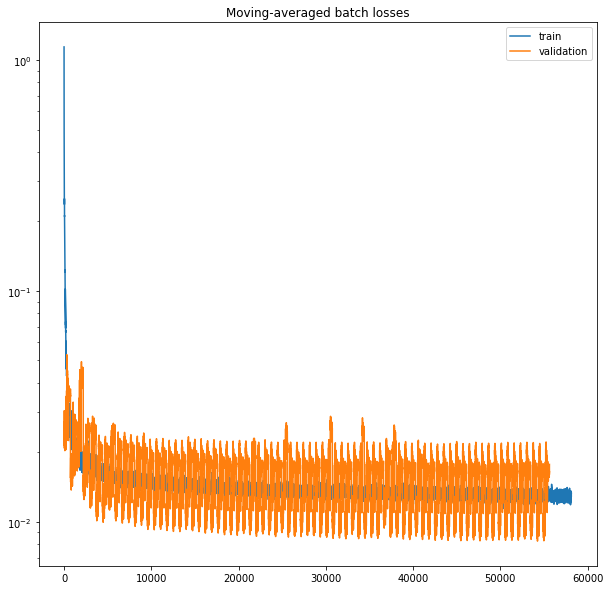

In [32]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [33]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

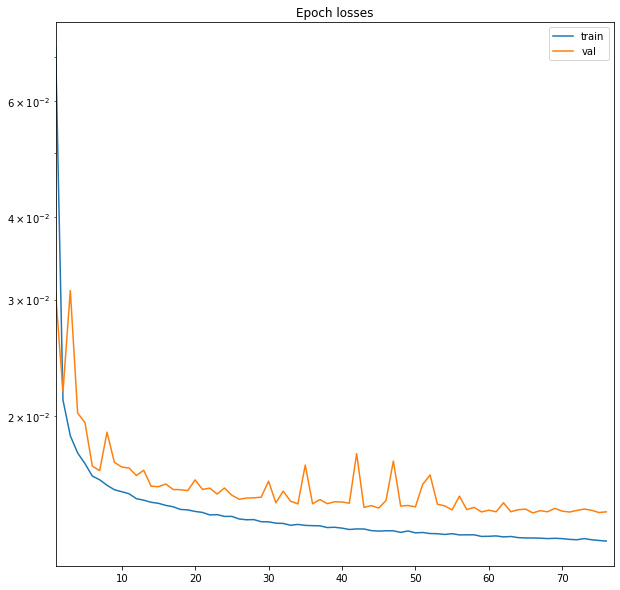

In [34]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [35]:
import pandas as pd

In [36]:
from visualization_utils import make_df

In [37]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996981,0.979863,0.981856,0.980859,0.998851,0.962437,carb96558,basic
1,0.989138,0.925722,0.989220,0.956418,0.983804,0.916476,carb71,basic
2,0.984184,0.969380,0.854781,0.908481,0.973506,0.832309,carbRNF,basic
3,0.992832,0.996552,0.907944,0.950187,0.996957,0.905101,SPE_carb10_58_box3,basic
4,0.991394,0.987126,0.921074,0.952957,0.995020,0.910141,SoilAh-1,basic
5,0.996220,0.974509,0.976300,0.975404,0.997986,0.951989,SoilB-2,basic
6,0.990270,0.996591,0.919572,0.956534,0.990609,0.916688,TeTree_subset1,basic
7,0.992933,0.996063,0.949968,0.972470,0.994653,0.946414,TiTree_subset2,basic
8,0.993749,0.971066,0.977943,0.974492,0.997937,0.950253,Urna_22,basic
9,0.991562,0.973800,0.977308,0.975550,0.998174,0.952268,Urna_30,basic


In [38]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.92195
Std    IOU: 0.037394
Min    IOU: 0.83231
Median IOU: 0.91669
